In [29]:
from pyspark.sql import functions as F
import pyspark_csv as pycsv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from os import path
import random
import re
from wordcloud import WordCloud, STOPWORDS, get_single_color_func

In [30]:
sc.addPyFile('pyspark_csv.py')

avisos_detalle = sqlContext.read.csv('fiuba_6_avisos_detalle.csv')

In [31]:
avisos_detalle.take(1)

[Row(_c0='idaviso', _c1='idpais', _c2='titulo', _c3='descripcion', _c4='nombre_zona', _c5='ciudad', _c6='mapacalle', _c7='tipo_de_trabajo', _c8='nivel_laboral', _c9='nombre_area', _c10='denominacion_empresa')]

In [32]:
avisos_detalle.dropna().select("_c2").take(100)

[Row(_c2='titulo'),
 Row(_c2='Personal con experiencia en lavandería  para Hotel 5 estrellas'),
 Row(_c2='VENDEDORES DE PLANES DE AHORRO'),
 Row(_c2='TECNICO SSr.  -Soporte a usuarios nivel 2-'),
 Row(_c2='Electricista para importante hotel 5*'),
 Row(_c2='Telemarketer - Operadores de Ventas'),
 Row(_c2='Asistente administrativo. Estudiantes de ciencias económicas e ing. industrial'),
 Row(_c2='Ejecutivo/a de Ventas para segmento Residencial - PRESENCIAL'),
 Row(_c2='Asistentes Administrativos con Inglés  y/o Portugués avanzado - Para Zona Norte o Microcentro.'),
 Row(_c2='Asistente de Empleos y Beneficios. '),
 Row(_c2='Analista de Operaciones'),
 Row(_c2='Jefe de planeamiento estratégico & control de gestión'),
 Row(_c2='Distribuidores p/ lectura de medidores de servicios'),
 Row(_c2='Jefe Higiene, Seguridad y Medio Ambiente'),
 Row(_c2='Promotor de Trade Marketing'),
 Row(_c2='Estibador/ra San Nicolas de los Arroyos'),
 Row(_c2='Distribuidor domiciliario con BICI'),
 Row(_c2='Produc

# Hacemos un split de cada palabra en el titulo

In [33]:
titulos = avisos_detalle.select("_c2").dropna()
titulos_rdd = titulos.rdd

In [34]:
titulos_rdd = titulos_rdd.flatMap(lambda row: row._c2.split() if row._c2 is not None else "")

In [35]:
titulos_rdd = titulos_rdd.map(lambda word: (str.lower(word).rstrip(',').rstrip('.').rstrip(':').rstrip(';'),1))

In [36]:
titulos_rdd.take(20)

[('titulo', 1),
 ('vendedor/a', 1),
 ('provincia', 1),
 ('de', 1),
 ('santa', 1),
 ('fe', 1),
 ('enfermeras', 1),
 ('chofer', 1),
 ('de', 1),
 ('taxi', 1),
 ('chofer', 1),
 ('de', 1),
 ('camioneta', 1),
 ('bahia', 1),
 ('blanca', 1),
 ('-', 1),
 ('punta', 1),
 ('alta', 1),
 ('operarios', 1),
 ('de', 1)]

In [37]:
titulos_rdd = titulos_rdd.reduceByKey(lambda a,b: a+b ).cache()

In [38]:
titulos_rdd.sortBy(ascending=False,keyfunc=lambda x:x[1]).take(10)

[('de', 8117),
 ('-', 3444),
 ('analista', 1776),
 ('para', 1744),
 ('zona', 1175),
 ('y', 1134),
 ('en', 1056),
 ('técnico', 641),
 ('con', 618),
 ('comercial', 603)]

In [49]:
#Quitamos palabras y caracteres que son indeseables o no tienen importancia
preposiciones = ["a","ante","cabe","bajo","con","contra","de","desde","durante","en","entre","hacia","hasta",\
                "mediante","para","por","segun","sin","sobre","tras"]

otras_palabras = ["y","con","en","la","las","el","al","-","del","1","uno","una","2","dos","3","tres","se","los","un",\
                 "que","es","o","4",",",".","m2","mls","null","través","son","x","en:","/","por:","no","null.","su",\
                  "publicado","cuenta","tipo","como","más","cada","sus","lo","está","e","","m","muy","mas","todo",\
                  "otro","total","san","//","(","\x96","plata","z/","rubro","zona","(zona",")","rosario","oeste",\
                 "córdoba","busca","p p","p","br","and","te","nos","tu","lang es","hs","the","span","p p se",\
                 "9","18","style span","style","style text decoration","to","p para","y o","p span","span p p",\
                 "of"]

In [40]:
titulos_rdd = titulos_rdd.filter(lambda word: word[0] not in preposiciones \
                                                   and word[0] not in otras_palabras).cache()

In [41]:
titulos_rdd.sortBy(ascending=False,keyfunc=lambda x:x[1]).take(90)

[('analista', 1776),
 ('técnico', 641),
 ('comercial', 603),
 ('administrativo', 540),
 ('ventas', 530),
 ('vendedor', 522),
 ('contable', 458),
 ('sr', 448),
 ('jefe', 411),
 ('asistente', 391),
 ('importante', 380),
 ('caba', 368),
 ('empresa', 352),
 ('supervisor', 344),
 ('ejecutivo', 335),
 ('jr', 323),
 ('mantenimiento', 320),
 ('norte', 294),
 ('responsable', 291),
 ('ingeniero', 287),
 ('operario', 268),
 ('experiencia', 265),
 ('senior', 249),
 ('gerente', 243),
 ('producción', 241),
 ('ssr', 228),
 ('asesor', 224),
 ('vendedores', 220),
 ('cuentas', 214),
 ('gba', 208),
 ('desarrollador', 203),
 ('atención', 202),
 ('personal', 202),
 ('venta', 191),
 ('operarios', 189),
 ('time', 189),
 ('administrativa', 186),
 ('capital', 186),
 ('cobranzas', 180),
 ('junior', 177),
 ('java', 176),
 ('cliente', 176),
 ('sur', 174),
 ('eventual', 172),
 ('programador', 169),
 ('oficial', 166),
 ('marketing', 152),
 ('soporte', 151),
 ('tecnico', 150),
 ('coordinador', 148),
 ('rrhh', 144),


In [14]:
dict_titulos = {}
list_titulos_ordenados = titulos_rdd.takeOrdered(90, lambda x: -x[1])
for a, x in list_titulos_ordenados:
    dict_titulos[a] = x

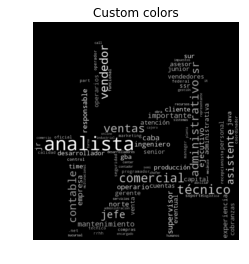

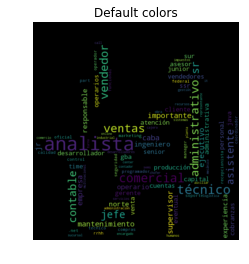

In [27]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

d = "/home/lucio/Imágenes/Imagenes Datos"

# read the mask image
mask = np.array(Image.open(path.join(d,"frustrated-computer-work-hi.png")))

wc = WordCloud(max_words=1000, mask=mask, stopwords=stopwords, margin=2,\
               random_state=1).generate_from_frequencies(frequencies= dict_titulos)

# store default colored image
default_colors = wc.to_array()
plt.title("Custom colors")
wc.to_file("World Cloud para titulos COLOR.png")
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),interpolation="bilinear")
wc.to_file("World Cloud para titulos BW.png")
plt.axis("off")
plt.figure()
plt.title("Default colors")
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()

# Hacemos split para las descripciones

In [42]:
descripciones = avisos_detalle.select("_c3").dropna()
descripciones_rdd = descripciones.rdd

In [43]:
descripciones_rdd = descripciones_rdd.flatMap(lambda row: row._c3.split() if row._c3 is not None else "")

In [44]:
rx = re.compile('\W+')
descripciones_rdd = descripciones_rdd.map(lambda word: (rx.sub(' ', str.lower(word)).strip(),1))

In [45]:
descripciones_rdd = descripciones_rdd.reduceByKey(lambda a,b: a+b ).cache()

In [50]:
descripciones_rdd = descripciones_rdd.filter(lambda word: word[0] not in preposiciones \
                                                   and word[0] not in otras_palabras).cache()

In [51]:
descripciones_rdd.sortBy(ascending=False,keyfunc=lambda x:x[1]).take(100)

[('experiencia', 8558),
 ('empresa', 5731),
 ('búsqueda', 5576),
 ('trabajo', 5443),
 ('años', 3531),
 ('tareas', 3153),
 ('importante', 2955),
 ('equipo', 2849),
 ('manejo', 2836),
 ('lunes', 2480),
 ('conocimientos', 2394),
 ('clientes', 2374),
 ('viernes', 2240),
 ('cliente', 2208),
 ('encontramos', 2098),
 ('desarrollo', 2084),
 ('encuentra', 2052),
 ('empresas', 2036),
 ('área', 1949),
 ('condiciones', 1892),
 ('trabajar', 1857),
 ('gestión', 1773),
 ('servicios', 1742),
 ('contar', 1729),
 ('laboral', 1717),
 ('disponibilidad', 1686),
 ('ventas', 1686),
 ('personal', 1682),
 ('comercial', 1660),
 ('p importante', 1636),
 ('capacidad', 1591),
 ('contratación', 1583),
 ('principales', 1577),
 ('administración', 1575),
 ('productos', 1551),
 ('nuestro', 1510),
 ('realizar', 1467),
 ('carreras', 1449),
 ('personas', 1438),
 ('sistemas', 1438),
 ('control', 1437),
 ('excelente', 1393),
 ('venta', 1342),
 ('nivel', 1332),
 ('atención', 1328),
 ('persona', 1297),
 ('calidad', 1277),
 ('

In [54]:
dict_descripts = {}
list_descripts_ordered = descripciones_rdd.takeOrdered(100, lambda x: -x[1])
for a, x in list_descripts_ordered:
    dict_descripts[a] = x
dict_descripts['importante'] += dict_descripts['p importante']
dict_descripts.pop('p importante')

1636

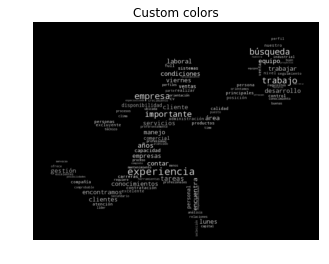

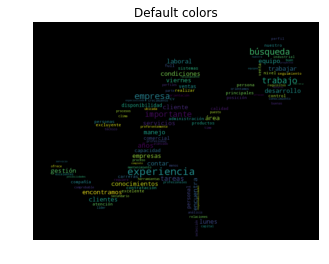

In [81]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

d = "/home/lucio/Imágenes/Imagenes Datos"

# read the mask image
mask = np.array(Image.open(path.join(d,"hombre-corriendo-maletin-silueta-sencilla.png")))

wc = WordCloud(max_words=1000, mask=mask, margin=2,\
               random_state=1).generate_from_frequencies(frequencies= dict_descripts)

# store default colored image
default_colors = wc.to_array()
plt.title("Custom colors")
wc.to_file("World Cloud para descripciones COLOR.png")
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3),interpolation="bilinear")
wc.to_file("World Cloud para descripciones BW.png")
plt.axis("off")
plt.figure()
plt.title("Default colors")
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()